# **Identifying Key Entities in Recipe Data**


**Business Objective**:
The goal of this assignment is to train a Named Entity Recognition (NER) model using Conditional Random Fields (CRF) to extract key entities from recipe data. The model will classify words into predefined categories such as ingredients, quantities and units, enabling the creation of a structured database of recipes and ingredients that can be used to power advanced features in recipe management systems, dietary tracking apps, or e-commerce platforms.

### **Data Description**
The given data is in JSON format, representing a **structured recipe ingredient list** with **Named Entity Recognition (NER) labels**. Below is a breakdown of the data fields:

```json
[
    {
        "input": "6 Karela Bitter Gourd Pavakkai Salt 1 Onion 3 tablespoon Gram flour besan 2 teaspoons Turmeric powder Haldi Red Chilli Cumin seeds Jeera Coriander Powder Dhania Amchur Dry Mango Sunflower Oil",
        "pos": "quantity ingredient ingredient ingredient ingredient ingredient quantity ingredient quantity unit ingredient ingredient ingredient quantity unit ingredient ingredient ingredient ingredient ingredient ingredient ingredient ingredient ingredient ingredient ingredient ingredient ingredient ingredient ingredient ingredient"
    },
    {
      "input": "2-1/2 cups rice cooked 3 tomatoes teaspoons BC Belle Bhat powder 1 teaspoon chickpea lentils 1/2 cumin seeds white urad dal mustard green chilli dry red 2 cashew or peanuts 1-1/2 tablespoon oil asafoetida",
      "pos": "quantity unit ingredient ingredient quantity ingredient unit ingredient ingredient ingredient ingredient quantity unit ingredient ingredient quantity ingredient ingredient ingredient ingredient ingredient ingredient ingredient ingredient ingredient ingredient quantity ingredient ingredient ingredient quantity unit ingredient ingredient"
    }
]


| **Key**  | **Description**  |
|----------|-----------------|
| `input`  | Contains a raw ingredient list from a recipe. |
| `pos`    | Represents the corresponding part-of-speech (POS) tags or NER labels, identifying quantities, ingredients, and units. |


## **1** Import libraries

#### **1.1** Installation of sklearn-crfsuite

sklearn-crfsuite is a Python wrapper for CRFsuite, a fast and efficient implementation of Conditional Random Fields (CRFs). It is designed to integrate seamlessly with scikit-learn for structured prediction tasks such as Named Entity Recognition (NER), Part-of-Speech (POS) tagging, and chunking.

In [2]:
# installation of sklearn_crfsuite
!pip install sklearn_crfsuite==0.5.0

   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 1.3/1.3 MB 28.6 MB/s eta 0:00:00


#### **1.2** Import necessary libraries

In [3]:
# Import warnings
import warnings
warnings.filterwarnings('ignore')

In [88]:
# Import necessary libraries
import json  # For handling JSON data
import pandas as pd  # For data manipulation and analysis
import re  # For regular expressions (useful for text preprocessing)
import matplotlib.pyplot as plt  # For visualisation
import seaborn as sns  # For advanced data visualisation
import sklearn_crfsuite  # CRF (Conditional Random Fields) implementation for sequence modeling
import numpy as np  # For numerical computations
# Saving and loading machine learning models
import joblib
import random
import spacy
from IPython.display import display, Markdown # For displaying well-formatted output

from fractions import Fraction  # For handling fractional values in numerical data
# Importing tools for feature engineering and model training
from collections import Counter  # For counting occurrences of elements in a list
from sklearn.model_selection import train_test_split  # For splitting dataset into train and test sets
from sklearn_crfsuite import metrics  # For evaluating CRF models
from sklearn_crfsuite.metrics import flat_classification_report
from sklearn.utils.class_weight import compute_class_weight
from collections import Counter
from sklearn.metrics import confusion_matrix

In [5]:
# Ensure pandas displays full content
pd.set_option('display.max_colwidth', None)
pd.set_option('display.expand_frame_repr', False)

## **2** Data Ingestion and Preparation <font color = red>[25 marks]</font> <br>

#### **2.1** *Read Recipe Data from Dataframe and prepare the data for analysis* <font color = red>[12 marks]</font> <br>
Read the data from JSON file, print first five rows and describe the dataframe

##### **2.1.1** **Define a *load_json_dataframe* function** <font color = red>[7 marks]</font> <br>

Define a function that takes path of the ingredient_and_quantity.json file and reads it, convert it into dataframe - df and return it.

In [6]:
# define a function to load json file to a dataframe
import pandas as pd
import json
from google.colab import files

def load_json_to_df():
    # Upload file from local computer
    uploaded = files.upload()

    # Get the uploaded file name
    filename = next(iter(uploaded))

    try:
        # Try reading as a standard JSON (records format)
        df = pd.read_json(filename)
    except ValueError:
        # If not in records format, use json.load + json_normalize
        with open(filename, 'r') as f:
            data = json.load(f)
        df = pd.json_normalize(data)

    return df

##### **2.1.2** **Execute the *load_json_dataframe* function** <font color = red>[2 marks]</font> <br>

In [8]:
# read the json file by giving the file path and create a dataframe
df = load_json_to_df()

Saving ingredient_and_quantity.json to ingredient_and_quantity (1).json


##### **2.1.3** **Describe the dataframe** <font color = red>[3 marks]</font> <br>

Print first five rows of dataframe along with dimensions. Display the information of dataframe

In [9]:
# display first five rows of the dataframe - df
df.head()

,input,pos
0,6 Karela Bitter Gourd Pavakkai Salt 1 Onion 3 tablespoon Gram flour besan 2 teaspoons Turmeric powder Haldi Red Chilli Cumin seeds Jeera Coriander Powder Dhania Amchur Dry Mango Sunflower Oil,quantity ingredient ingredient ingredient ingredient ingredient quantity ingredient quantity unit ingredient ingredient ingredient quantity unit ingredient ingredient ingredient ingredient ingredient ingredient ingredient ingredient ingredient ingredient ingredient ingredient ingredient ingredient ingredient ingredient
1,2-1/2 cups rice cooked 3 tomatoes teaspoons BC Belle Bhat powder 1 teaspoon chickpea lentils 1/2 cumin seeds white urad dal mustard green chilli dry red 2 cashew or peanuts 1-1/2 tablespoon oil asafoetida,quantity unit ingredient ingredient quantity ingredient unit ingredient ingredient ingredient ingredient quantity unit ingredient ingredient quantity ingredient ingredient ingredient ingredient ingredient ingredient ingredient ingredient ingredient ingredient quantity ingredient ingredient ingredient quantity unit ingredient ingredient
2,1-1/2 cups Rice Vermicelli Noodles Thin 1 Onion sliced 1/2 cup Carrots Gajjar chopped 1/3 Green peas Matar 2 Chillies 1/4 teaspoon Asafoetida hing Mustard seeds White Urad Dal Split Ghee sprig Curry leaves Salt Lemon juice,quantity unit ingredient ingredient ingredient ingredient quantity ingredient ingredient quantity unit ingredient ingredient ingredient quantity ingredient ingredient ingredient quantity ingredient quantity unit ingredient ingredient ingredient ingredient ingredient ingredient ingredient ingredient ingredient unit ingredient ingredient ingredient ingredient ingredient
3,500 grams Chicken 2 Onion chopped 1 Tomato 4 Green Chillies slit inch Ginger finely 6 cloves Garlic 1/2 teaspoon Turmeric powder Haldi Garam masala tablespoon Sesame Gingelly Oil 1/4 Methi Seeds Fenugreek Coriander Dhania Dry Red Fennel seeds Saunf cups Sorrel Leaves Gongura picked and,quantity unit ingredient quantity ingredient ingredient quantity ingredient quantity ingredient ingredient ingredient unit ingredient ingredient quantity unit ingredient quantity unit ingredient ingredient ingredient ingredient ingredient unit ingredient ingredient ingredient quantity ingredient ingredient ingredient ingredient ingredient ingredient ingredient ingredient ingredient ingredient unit ingredient ingredient ingredient ingredient ingredient
4,1 tablespoon chana dal white urad 2 red chillies coriander seeds 3 inches ginger onion tomato Teaspoon mustard asafoetida sprig curry,quantity unit ingredient ingredient ingredient ingredient quantity ingredient ingredient ingredient ingredient quantity unit ingredient ingredient ingredient unit ingredient ingredient unit ingredient


In [10]:
# print the dimensions of dataframe - df
df.shape

(285, 2)

In [11]:
# print the information of the dataframe
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 285 entries, 0 to 284
Data columns (total 2 columns):
 #   Column  Non-Null Count  Dtype 
---  ------  --------------  ----- 
 0   input   285 non-null    object
 1   pos     285 non-null    object
dtypes: object(2)
memory usage: 4.6+ KB


#### **2.2** *Recipe Data Manipulation* <font color = red>[13 marks]</font> <br>
Create derived metrics in dataframe and provide insights of the dataframe

##### **2.2.1** **Create input_tokens and pos_tokens columns by splitting the input and pos from the dataframe** <font color = red>[3 marks]</font> <br>
Split the input and pos into input_tokens and pos_tokens in the dataframe and display it in the dataframe

In [13]:
# split the input and pos into input_tokens and pos_tokens in the dataframe

# Tokenize input
df['input_tokens'] = df['input'].apply(lambda x: x.strip().split())

# Tokenize POS
df['pos_tokens'] = df['pos'].apply(lambda x: x.strip().split())

In [14]:
# display first five rows of the dataframe - df
df.head()

,input,pos,input_tokens,pos_tokens
0,6 Karela Bitter Gourd Pavakkai Salt 1 Onion 3 tablespoon Gram flour besan 2 teaspoons Turmeric powder Haldi Red Chilli Cumin seeds Jeera Coriander Powder Dhania Amchur Dry Mango Sunflower Oil,quantity ingredient ingredient ingredient ingredient ingredient quantity ingredient quantity unit ingredient ingredient ingredient quantity unit ingredient ingredient ingredient ingredient ingredient ingredient ingredient ingredient ingredient ingredient ingredient ingredient ingredient ingredient ingredient ingredient,"[6, Karela, Bitter, Gourd, Pavakkai, Salt, 1, Onion, 3, tablespoon, Gram, flour, besan, 2, teaspoons, Turmeric, powder, Haldi, Red, Chilli, Cumin, seeds, Jeera, Coriander, Powder, Dhania, Amchur, Dry, Mango, Sunflower, Oil]","[quantity, ingredient, ingredient, ingredient, ingredient, ingredient, quantity, ingredient, quantity, unit, ingredient, ingredient, ingredient, quantity, unit, ingredient, ingredient, ingredient, ingredient, ingredient, ingredient, ingredient, ingredient, ingredient, ingredient, ingredient, ingredient, ingredient, ingredient, ingredient, ingredient]"
1,2-1/2 cups rice cooked 3 tomatoes teaspoons BC Belle Bhat powder 1 teaspoon chickpea lentils 1/2 cumin seeds white urad dal mustard green chilli dry red 2 cashew or peanuts 1-1/2 tablespoon oil asafoetida,quantity unit ingredient ingredient quantity ingredient unit ingredient ingredient ingredient ingredient quantity unit ingredient ingredient quantity ingredient ingredient ingredient ingredient ingredient ingredient ingredient ingredient ingredient ingredient quantity ingredient ingredient ingredient quantity unit ingredient ingredient,"[2-1/2, cups, rice, cooked, 3, tomatoes, teaspoons, BC, Belle, Bhat, powder, 1, teaspoon, chickpea, lentils, 1/2, cumin, seeds, white, urad, dal, mustard, green, chilli, dry, red, 2, cashew, or, peanuts, 1-1/2, tablespoon, oil, asafoetida]","[quantity, unit, ingredient, ingredient, quantity, ingredient, unit, ingredient, ingredient, ingredient, ingredient, quantity, unit, ingredient, ingredient, quantity, ingredient, ingredient, ingredient, ingredient, ingredient, ingredient, ingredient, ingredient, ingredient, ingredient, quantity, ingredient, ingredient, ingredient, quantity, unit, ingredient, ingredient]"
2,1-1/2 cups Rice Vermicelli Noodles Thin 1 Onion sliced 1/2 cup Carrots Gajjar chopped 1/3 Green peas Matar 2 Chillies 1/4 teaspoon Asafoetida hing Mustard seeds White Urad Dal Split Ghee sprig Curry leaves Salt Lemon juice,quantity unit ingredient ingredient ingredient ingredient quantity ingredient ingredient quantity unit ingredient ingredient ingredient quantity ingredient ingredient ingredient quantity ingredient quantity unit ingredient ingredient ingredient ingredient ingredient ingredient ingredient ingredient ingredient unit ingredient ingredient ingredient ingredient ingredient,"[1-1/2, cups, Rice, Vermicelli, Noodles, Thin, 1, Onion, sliced, 1/2, cup, Carrots, Gajjar, chopped, 1/3, Green, peas, Matar, 2, Chillies, 1/4, teaspoon, Asafoetida, hing, Mustard, seeds, White, Urad, Dal, Split, Ghee, sprig, Curry, leaves, Salt, Lemon, juice]","[quantity, unit, ingredient, ingredient, ingredient, ingredient, quantity, ingredient, ingredient, quantity, unit, ingredient, ingredient, ingredient, quantity, ingredient, ingredient, ingredient, quantity, ingredient, quantity, unit, ingredient, ingredient, ingredient, ingredient, ingredient, ingredient, ingredient, ingredient, ingredient, unit, ingredient, ingredient, ingredient, ingredient, ingredient]"
3,500 grams Chicken 2 Onion chopped 1 Tomato 4 Green Chillies slit inch Ginger finely 6 cloves Garlic 1/2 teaspoon Turmeric powder Haldi Garam masala tablespoon Sesame Gingelly Oil 1/4 Methi Seeds Fenugreek Coriander Dhania Dry Red Fennel seeds Saunf cups Sorrel Leaves Gongura picked and,quantity unit ingredient quantity ingredient ingredient quantity ingredient quantity ingredient ingredient ingredient unit ingredient ingredient qua

##### **2.2.2** **Provide the length for input_tokens and pos_tokens and validate their length** <font color = red>[2 marks]</font> <br>

Create input_length and pos_length columns in the dataframe and validate both the lengths. Check for the rows that are unequal in input and pos length


In [15]:
# create input_length and pos_length columns for the input_tokens and pos-tokens
df['input_length'] = df['input_tokens'].apply(len)
df['pos_length'] = df['pos_tokens'].apply(len)

In [17]:
# check for the equality of input_length and pos_length in the dataframe
# Create a new column to check equality
df['length_match'] = df['input_length'] == df['pos_length']

# Optionally, filter rows where there's a mismatch
mismatched_rows = df[~df['length_match']]

# Show results
print(f"Total mismatches: {len(mismatched_rows)}")
mismatched_rows[['input', 'pos', 'input_length', 'pos_length']]

Total mismatches: 5


,input,pos,input_length,pos_length
17,2 cups curd 1 cup gourd cucumber green cor coriander 1/2 teaspoon cumin powder salt,quantity unit ingredient quantity unit ingredient ingredient ingredient ingredient quantity unit ingredient ingredient ingredient,15,14
27,1 Baguette sliced 1 1/2 tablespoon Butter 1/2 Garlic minced cup Spinach Leaves Palak Red Bell pepper Capsicum Tomato finely chopped Onion Black powder Italian seasoning teaspoon Fresh cream Cheddar cheese grated Salt Roasted tomato pasta sauce,quantity ingredient ingredient quantity unit ingredient quantity ingredient ingredient unit ingredient ingredient ingredient ingredient ingredient ingredient ingredient ingredient ingredient ingredient ingredient ingredient ingredient ingredient ingredient unit ingredient ingredient ingredient ingredient ingredient ingredient ingredient ingredient ingredient ingredient,37,36
79,1/2 cup Poha Flattened rice 2 tablespoons Rice flour 2 1/2 liter Milk 1 Nolen Gur or brown sugar Cardamom Elaichi Pods/Seeds 8-10 Mixed nuts almonds/cashews tablespoon Raisins pinch Saffron strands and a little more for garnish Salt,quantity unit ingredient ingredient ingredient quantity unit ingredient ingredient quantity unit ingredient quantity ingredient ingredient ingredient ingredient ingredient ingredient ingredient ingredient quantity ingredient ingredient ingredient unit ingredient unit ingredient ingredient ingredient ingredient ingredient ingredient ingredient ingredient ingredient,38,37
164,1/2 cup All Purpose Flour Maida Whole Wheat 1/4 Hung Curd Greek Yogurt 250 grams Chicken minced 1 Spinach Leaves Palak finely chopped Onion 4 cloves Garlic Tomatoes tablespoon Cumin powder Jeera Coriander Powder Dhania 1 1/2 teaspoon Paprika Black pepper 3 sprig Mint Pudina 10 Spring Bulb & Greens 100 Feta Cheese crumbled,quantity unit ingredient ingredient ingredient ingredient ingredient ingredient quantity ingredient ingredient ingredient ingredient quantity unit ingredient ingredient quantity ingredient ingredient ingredient ingredient ingredient ingredient quantity unit ingredient ingredient unit ingredient ingredient ingredient ingredient ingredient ingredient quantity unit ingredient ingredient ingredient quantity unit ingredient ingredient quantity ingredient ingredient ingredient ingredient quantity ingredient ingredient ingredient,54,53
207,1 cup Cashew nuts Badam Almond 1 1/4 cups Sugar 1/2 Water teaspoon Cardamom Powder Ghee for greasing,quantity unit ingredient ingredient ingredient ingredient quantity unit ingredient quantity ingredient unit ingredient ingredient ingredient unit ingredient,18,17


##### **2.2.3** **Define a unique_labels function and validate the labels in pos_tokens** <font color = red>[2 marks]</font> <br>

Define a unique_labels function which checks for all the unique pos labels in the recipe & execute it.


In [18]:
# Define a unique_labels function to checks for all the unique pos labels in the recipe & print it
def unique_labels(df):
    """
    Prints all unique POS labels from the 'pos_tokens' column in the DataFrame.
    """
    if 'pos_tokens' not in df.columns:
        raise ValueError("Column 'pos_tokens' not found in DataFrame. Please tokenize POS tags first.")

    # Flatten the list of lists and get unique labels
    unique_pos = set(tag for row in df['pos_tokens'] for tag in row)

    print("Unique POS labels:")
    print(sorted(unique_pos))

# Example usage:
unique_labels(df)

Unique POS labels:
['ingredient', 'quantity', 'unit']


##### **2.2.3** **Provide the insights seen in the recipe data after validation** <font color = red>[1 marks]</font> <br>

Provide the indexes that requires cleaning and formatting in the dataframe

In [23]:
def validate_recipe_data(df):
    """
    Validates the recipe POS-tagged dataset and prints insights.
    Returns indexes that require cleaning/formatting.
    """
    issues = []

    # 1. Length mismatch between tokens and POS tags
    df['length_match'] = df['input_length'] == df['pos_length']
    mismatch_indexes = df[~df['length_match']].index.tolist()
    if mismatch_indexes:
        issues.extend(mismatch_indexes)
        print(f"[!] Found {len(mismatch_indexes)} rows with token-POS length mismatch.")

    # 2. Null values in inputs or pos
    null_indexes = df[df[['input', 'pos']].isnull().any(axis=1)].index.tolist()
    if null_indexes:
        issues.extend(null_indexes)
        print(f"[!] Found {len(null_indexes)} rows with null values.")

    # 3. Empty strings or tokens
    empty_inputs = df[df['input'].str.strip() == ''].index.tolist()
    empty_pos = df[df['pos'].str.strip() == ''].index.tolist()
    if empty_inputs:
        issues.extend(empty_inputs)
        print(f"[!] Found {len(empty_inputs)} rows with empty 'inputs' string.")
    if empty_pos:
        issues.extend(empty_pos)
        print(f"[!] Found {len(empty_pos)} rows with empty 'pos' string.")

    # 4. Empty token lists
    empty_token_rows = df[df['input_tokens'].apply(len) == 0].index.tolist()
    empty_pos_token_rows = df[df['pos_tokens'].apply(len) == 0].index.tolist()
    if empty_token_rows:
        issues.extend(empty_token_rows)
        print(f"[!] Found {len(empty_token_rows)} rows with empty input tokens.")
    if empty_pos_token_rows:
        issues.extend(empty_pos_token_rows)
        print(f"[!] Found {len(empty_pos_token_rows)} rows with empty POS tokens.")

    # Print summary
    total_issues = len(set(issues))
    print(f"\n Total rows requiring cleaning/formatting: {total_issues}")

    # Return unique, sorted list of problematic indexes
    return sorted(set(issues))

# Example usage:
problem_indexes = validate_recipe_data(df)

[!] Found 5 rows with token-POS length mismatch.

 Total rows requiring cleaning/formatting: 5


In [24]:
problem_indexes

[17, 27, 79, 164, 207]

<font color = red>[The total rows that require formatting/cleaning are 5. They are 17, 27, 79, 164 and 207]</font> <br>


##### **2.2.4** **Drop the rows that have invalid data provided in previous cell** <font color = red> [2 marks]</font> <br>

In [25]:
# drop the irrelevant recipe data
df_cleaned = df.drop(index=problem_indexes).reset_index(drop=True)
print(f"Cleaned DataFrame has {len(df_cleaned)} rows (from {len(df)} originally).")

Cleaned DataFrame has 280 rows (from 285 originally).


##### **2.2.5** **Update the input_length & pos_length in dataframe**<font color = red> [2 marks]</font> <br>

In [26]:
# update the input and pos length in input_length and pos_length
df_cleaned['input_length'] = df_cleaned['input_tokens'].apply(len)
df_cleaned['pos_length'] = df_cleaned['pos_tokens'].apply(len)
df_cleaned.head(2)

,input,pos,input_tokens,pos_tokens,input_length,pos_length,length_match
0,6 Karela Bitter Gourd Pavakkai Salt 1 Onion 3 tablespoon Gram flour besan 2 teaspoons Turmeric powder Haldi Red Chilli Cumin seeds Jeera Coriander Powder Dhania Amchur Dry Mango Sunflower Oil,quantity ingredient ingredient ingredient ingredient ingredient quantity ingredient quantity unit ingredient ingredient ingredient quantity unit ingredient ingredient ingredient ingredient ingredient ingredient ingredient ingredient ingredient ingredient ingredient ingredient ingredient ingredient ingredient ingredient,"[6, Karela, Bitter, Gourd, Pavakkai, Salt, 1, Onion, 3, tablespoon, Gram, flour, besan, 2, teaspoons, Turmeric, powder, Haldi, Red, Chilli, Cumin, seeds, Jeera, Coriander, Powder, Dhania, Amchur, Dry, Mango, Sunflower, Oil]","[quantity, ingredient, ingredient, ingredient, ingredient, ingredient, quantity, ingredient, quantity, unit, ingredient, ingredient, ingredient, quantity, unit, ingredient, ingredient, ingredient, ingredient, ingredient, ingredient, ingredient, ingredient, ingredient, ingredient, ingredient, ingredient, ingredient, ingredient, ingredient, ingredient]",31,31,True
1,2-1/2 cups rice cooked 3 tomatoes teaspoons BC Belle Bhat powder 1 teaspoon chickpea lentils 1/2 cumin seeds white urad dal mustard green chilli dry red 2 cashew or peanuts 1-1/2 tablespoon oil asafoetida,quantity unit ingredient ingredient quantity ingredient unit ingredient ingredient ingredient ingredient quantity unit ingredient ingredient quantity ingredient ingredient ingredient ingredient ingredient ingredient ingredient ingredient ingredient ingredient quantity ingredient ingredient ingredient quantity unit ingredient ingredient,"[2-1/2, cups, rice, cooked, 3, tomatoes, teaspoons, BC, Belle, Bhat, powder, 1, teaspoon, chickpea, lentils, 1/2, cumin, seeds, white, urad, dal, mustard, green, chilli, dry, red, 2, cashew, or, peanuts, 1-1/2, tablespoon, oil, asafoetida]","[quantity, unit, ingredient, ingredient, quantity, ingredient, unit, ingredient, ingredient, ingredient, ingredient, quantity, unit, ingredient, ingredient, quantity, ingredient, ingredient, ingredient, ingredient, ingredient, ingredient, ingredient, ingredient, ingredient, ingredient, quantity, ingredient, ingredient, ingredient, quantity, unit, ingredient, ingredient]",34,34,True


##### **2.2.6** **Validate the input_length and pos_length by checking unequal rows** <font color = red> [1 marks]</font> <br>

In [28]:
# validate the input length and pos length as input_length and pos_length
df_cleaned[df_cleaned['length_match']==False]

,input,pos,input_tokens,pos_tokens,input_length,pos_length,length_match


## **3** Train Validation Split (70 train - 30 val) <font color = red>[6 marks]</font> <br>

#### **3.1** *Perform train and validation split ratio* <font color = red>[6 marks]</font> <br>
Split the dataset with the help of input_tokens and pos_tokens and make a ratio of 70:30 split for training and validation datasets.

###### **3.1.1** **Split the dataset into train_df and val_df into 70:30 ratio** <font color = red> [1 marks]</font> <br>

In [30]:
# split the dataset into training and validation sets
train_df, val_df = train_test_split(df_cleaned, test_size=0.3, random_state=42)

print(f"Split complete: {len(train_df)} train samples, {len(val_df)} validation samples.")

Split complete: 196 train samples, 84 validation samples.


###### **3.1.2** **Print the first five rows of train_df and val_df** <font color = red> [1 marks]</font> <br>

In [31]:
# print the first five rows of train_df
train_df.head()

,input,pos,input_tokens,pos_tokens,input_length,pos_length,length_match
175,250 grams Okra Oil 1 Onion finely chopped Tomato Grated teaspoon Ginger 2 Garlic Finely 1/2 Cumin seeds 1/4 Teaspoon asafoetida cup cottage cheese pinched coriander powder mango red chilli turmeric,quantity unit ingredient ingredient quantity ingredient ingredient ingredient ingredient ingredient unit ingredient quantity ingredient ingredient quantity ingredient ingredient quantity unit ingredient unit ingredient ingredient ingredient ingredient ingredient ingredient ingredient ingredient ingredient,"[250, grams, Okra, Oil, 1, Onion, finely, chopped, Tomato, Grated, teaspoon, Ginger, 2, Garlic, Finely, 1/2, Cumin, seeds, 1/4, Teaspoon, asafoetida, cup, cottage, cheese, pinched, coriander, powder, mango, red, chilli, turmeric]","[quantity, unit, ingredient, ingredient, quantity, ingredient, ingredient, ingredient, ingredient, ingredient, unit, ingredient, quantity, ingredient, ingredient, quantity, ingredient, ingredient, quantity, unit, ingredient, unit, ingredient, ingredient, ingredient, ingredient, ingredient, ingredient, ingredient, ingredient, ingredient]",31,31,True
55,200 grams Paneer Homemade Cottage Cheese 2 Potato Aloo Bay leaf tej patta Dry Red Chilli 1 tablespoon Panch Phoran Masala roasted and powdered Tomato big sized teaspoon Turmeric powder Haldi Cumin seeds Jeera Ginger grated Salt 1/2 Sugar Sunflower Oil,quantity unit ingredient ingredient ingredient ingredient quantity ingredient ingredient ingredient ingredient ingredient ingredient ingredient ingredient ingredient quantity unit ingredient ingredient ingredient ingredient ingredient ingredient ingredient ingredient ingredient unit ingredient ingredient ingredient ingredient ingredient ingredient ingredient ingredient ingredient quantity ingredient ingredient ingredient,"[200, grams, Paneer, Homemade, Cottage, Cheese, 2, Potato, Aloo, Bay, leaf, tej, patta, Dry, Red, Chilli, 1, tablespoon, Panch, Phoran, Masala, roasted, and, powdered, Tomato, big, sized, teaspoon, Turmeric, powder, Haldi, Cumin, seeds, Jeera, Ginger, grated, Salt, 1/2, Sugar, Sunflower, Oil]","[quantity, unit, ingredient, ingredient, ingredient, ingredient, quantity, ingredient, ingredient, ingredient, ingredient, ingredient, ingredient, ingredient, ingredient, ingredient, quantity, unit, ingredient, ingredient, ingredient, ingredient, ingredient, ingredient, ingredient, ingredient, ingredient, unit, ingredient, ingredient, ingredient, ingredient, ingredient, ingredient, ingredient, ingredient, ingredient, quantity, ingredient, ingredient, ingredient]",41,41,True
109,500 grams Cabbage Patta Gobi Muttaikose 1 teaspoon Mustard seeds 1-1/2 White Urad Dal Split sprig Curry leaves Green Chilli 1/4 cup Fresh coconut Salt,quantity unit ingredient ingredient ingredient ingredient quantity unit ingredient ingredient quantity ingredient ingredient ingredient ingredient unit ingredient ingredient ingredient ingredient quantity unit ingredient ingredient ingredient,"[500, grams, Cabbage, Patta, Gobi, Muttaikose, 1, teaspoon, Mustard, seeds, 1-1/2, White, Urad, Dal, Split, sprig, Curry, leaves, Green, Chilli, 1/4, cup, Fresh, coconut, Salt]","[quantity, unit, ingredient, ingredient, ingredient, ingredient, quantity, unit, ingredient, ingredient, quantity, ingredient, ingredient, ingredient, ingredient, unit, ingredient, ingredient, ingredient, ingredient, quantity, unit, ingredient, ingredient, ingredient]",25,25,True
213,500 grams Fresh Figs 1/4 cup Lemon juice 1 teaspoon zest 2 Red Chilli flakes 1/2 Honey Brown Sugar (Demerara Sugar),quantity unit ingredient ingredient quantity unit ingredient ingredient quantity unit ingredient quantity ingredient ingredient ingredient quantity ingredient ingredient ingredient ingredient ingredient,"[500, grams, Fresh, Figs, 1/4, cup, Lemon, juice, 1, teaspoon, zest, 2, Red, Chilli, flakes, 1/2, Honey, Brown, Sugar, (Demerara, Sugar)]","[quantity, unit, ingredient, ingredient, quantity, unit,

In [32]:
# print the first five rows of the val_df
val_df.head()

,input,pos,input_tokens,pos_tokens,input_length,pos_length,length_match
33,1 cup Ada 2 liter Milk 3/4 Sugar tablespoon Ghee 1/2 teaspoon Cardamom Powder Elaichi,quantity unit ingredient quantity unit ingredient quantity ingredient unit ingredient quantity unit ingredient ingredient ingredient,"[1, cup, Ada, 2, liter, Milk, 3/4, Sugar, tablespoon, Ghee, 1/2, teaspoon, Cardamom, Powder, Elaichi]","[quantity, unit, ingredient, quantity, unit, ingredient, quantity, ingredient, unit, ingredient, quantity, unit, ingredient, ingredient, ingredient]",15,15,True
108,1 Carrot Gajjar chopped 7 Potatoes Aloo 2 cups Cauliflower gobi cut to small florets Onion tablespoon Ginger Garlic Paste Salt teaspoons Sunflower Oil 1/2 cup Fresh coconut grated teaspoon Whole Black Peppercorns Green Chillies Fennel seeds Saunf Poppy 6 Cashew nuts inch Cinnamon Stick Dalchini Star anise 3 Cloves Laung Cardamom Elaichi Pods/Seeds Cumin Jeera,quantity ingredient ingredient ingredient quantity ingredient ingredient quantity unit ingredient ingredient ingredient ingredient ingredient ingredient ingredient unit ingredient ingredient ingredient ingredient unit ingredient ingredient quantity unit ingredient ingredient ingredient unit ingredient ingredient ingredient ingredient ingredient ingredient ingredient ingredient ingredient quantity ingredient ingredient unit ingredient ingredient ingredient ingredient ingredient quantity ingredient ingredient ingredient ingredient ingredient ingredient ingredient,"[1, Carrot, Gajjar, chopped, 7, Potatoes, Aloo, 2, cups, Cauliflower, gobi, cut, to, small, florets, Onion, tablespoon, Ginger, Garlic, Paste, Salt, teaspoons, Sunflower, Oil, 1/2, cup, Fresh, coconut, grated, teaspoon, Whole, Black, Peppercorns, Green, Chillies, Fennel, seeds, Saunf, Poppy, 6, Cashew, nuts, inch, Cinnamon, Stick, Dalchini, Star, anise, 3, Cloves, Laung, Cardamom, Elaichi, Pods/Seeds, Cumin, Jeera]","[quantity, ingredient, ingredient, ingredient, quantity, ingredient, ingredient, quantity, unit, ingredient, ingredient, ingredient, ingredient, ingredient, ingredient, ingredient, unit, ingredient, ingredient, ingredient, ingredient, unit, ingredient, ingredient, quantity, unit, ingredient, ingredient, ingredient, unit, ingredient, ingredient, ingredient, ingredient, ingredient, ingredient, ingredient, ingredient, ingredient, quantity, ingredient, ingredient, unit, ingredient, ingredient, ingredient, ingredient, ingredient, quantity, ingredient, ingredient, ingredient, ingredient, ingredient, ingredient, ingredient]",56,56,True
240,1 tablespoon Sunflower Oil 3 Potato Aloo Ginger paste Green Chilli chopped 1-1/12 tablespoons Sesame seeds Til teaspoon Red powder Cumin Jeera Coriander Powder Dhania 1/2 Garam masala 2 Sweet Chutney Date Tamarind Leaves few,quantity unit ingredient ingredient quantity ingredient ingredient ingredient ingredient ingredient ingredient ingredient quantity unit ingredient ingredient ingredient unit ingredient ingredient ingredient ingredient ingredient ingredient ingredient quantity ingredient ingredient quantity ingredient ingredient ingredient ingredient ingredient ingredient,"[1, tablespoon, Sunflower, Oil, 3, Potato, Aloo, Ginger, paste, Green, Chilli, chopped, 1-1/12, tablespoons, Sesame, seeds, Til, teaspoon, Red, powder, Cumin, Jeera, Coriander, Powder, Dhania, 1/2, Garam, masala, 2, Sweet, Chutney, Date, Tamarind, Leaves, few]","[quantity, unit, ingredient, ingredient, quantity, ingredient, ingredient, ingredient, ingredient, ingredient, ingredient, ingredient, quantity, unit, ingredient, ingredient, ingredient, unit, ingredient, ingredient, ingredient, ingredient, ingredient, ingredient, ingredient, quantity, ingredient, ingredient, quantity, ingredient, ingredient, ingredient, ingredient, ingredient, ingredient]",35,35,True
259,1 cup green peas gram flour 1/2 cheese tsp ginger 2 chillies turmeric powder cumin teaspoon salt oil,quantity unit ingredient ingredient ingredient ingredient quantity ingredient unit ingr

###### **3.1.3** **Extract the dataset into train_df and val_df into X_train, X_val, y_train and y_val and display their length** <font color = red> [2 marks]</font> <br>

Extract X_train, X_val, y_train and y_val by extracting the list of input_tokens and pos_tokens from train_df and val_df and also display their length

In [38]:
# extract the training and validation sets by taking input_tokens and pos_tokens
def extract_from_splits(train_df, val_df):
    """
    Extracts X_train, y_train, X_val, y_val from train and validation DataFrames.

    Returns:
        X_train: list of input token sequences from train_df
        y_train: list of POS tag sequences from train_df
        X_val: list of input token sequences from val_df
        y_val: list of POS tag sequences from val_df
    """
    if 'input_tokens' not in train_df.columns or 'pos_tokens' not in train_df.columns:
        raise ValueError("train_df must contain 'input_tokens' and 'pos_tokens' columns.")
    if 'input_tokens' not in val_df.columns or 'pos_tokens' not in val_df.columns:
        raise ValueError("val_df must contain 'input_tokens' and 'pos_tokens' columns.")

    X_train = train_df['input_tokens']
    y_train = train_df['pos_tokens']
    X_val = val_df['input_tokens']
    y_val = val_df['pos_tokens']

    print(f"Extracted: {len(X_train)} X_train, {len(y_train)} y_train, {len(X_val)} X_val, {len(y_val)} y_val")
    return X_train, X_val, y_train, y_val

X_train, X_val, y_train, y_val = extract_from_splits(train_df, val_df)

Extracted: 196 X_train, 196 y_train, 84 X_val, 84 y_val


In [42]:
# validate the shape of training and validation samples
print(f'The shape of X_train is {X_train.shape}')
print(f'The shape of y_train is {y_train.shape}')
print(f'The shape of X_val is {X_val.shape}')
print(f'The shape of y_val is {y_val.shape}')

The shape of X_train is (196,)
The shape of y_train is (196,)
The shape of X_val is (84,)
The shape of y_val is (84,)


###### **3.1.4** **Display the number of unique labels present in y_train** <font color = red> [2 marks]</font> <br>

In [45]:
# Display the number of unique labels present in y_train
unique_labels = set(label for seq in y_train for label in seq)
print(f"Number of unique POS labels in y_train: {len(unique_labels)}")
print(f"Labels: {sorted(unique_labels)}")

Number of unique POS labels in y_train: 3
Labels: ['ingredient', 'quantity', 'unit']


## **4** Exploratory Recipe Data Analysis on Training Dataset <font color = red>[16 marks]</font> <br>

#### **4.1** *Flatten the lists for input_tokens & pos_tokens* <font color = red>[2 marks]</font> <br>

Define a function **flatten_list** for flattening the structure for input_tokens and pos_tokens. The input parameter passed to this function is a nested list.

Initialise the dataset_name with a value ***'Training'***




In [46]:
# flatten the list for nested_list (input_tokens, pos_tokens)
def flatten_nested_list(nested_list):
    """
    Flattens a list of lists into a single flat list.

    Args:
        nested_list (list of lists): Input like input_tokens or pos_tokens.

    Returns:
        flat_list (list): A single flat list of all tokens.
    """
    return [item for sublist in nested_list for item in sublist]

In [47]:
# initialise the dataset_name
dataset_name = 'Training'

#### **4.2** *Extract and validate the tokens after using the flattening technique* <font color = red>[2 marks]</font> <br>

Define a function named ***extract_and_validate_tokens*** with parameters dataframe and dataset_name (Training/Validation), validate the length of input_tokens and pos_tokens from dataframe and display first 10 records for both the input_tokens and pos_tokens. Execute this function




In [48]:
# define a extract_and_validate_tokens with parameters (df, dataset_name)
# call the flatten_list and apply it on input_tokens and pos_tokens
# validate their length and display first 10 records having input and pos tokens
def extract_and_validate_tokens(df, dataset_name):
    """
    Flattens input and POS tokens, validates their lengths, and displays sample token pairs.

    Args:
        df (pd.DataFrame): DataFrame with 'input_tokens' and 'pos_tokens'
        dataset_name (str): Name of the dataset (e.g., 'training')

    Returns:
        flat_inputs, flat_pos: Flattened input and POS token lists
    """
    flat_inputs = flatten_nested_list(df['input_tokens'].tolist())
    flat_pos = flatten_nested_list(df['pos_tokens'].tolist())

    print(f"Extracted tokens from {dataset_name} dataset.")
    print(f"- Total input tokens: {len(flat_inputs)}")
    print(f"- Total POS tokens: {len(flat_pos)}")

    if len(flat_inputs) != len(flat_pos):
        print("Mismatch: input_tokens and pos_tokens lengths do not match!")
    else:
        print("Lengths are equal.")

    # Display first 10 token pairs
    print("\nFirst 10 token-label pairs:")
    for token, label in list(zip(flat_inputs, flat_pos))[:10]:
        print(f"{token} --> {label}")

    return flat_inputs, flat_pos


flat_input_tokens, flat_pos_tokens = extract_and_validate_tokens(train_df, "training")

Extracted tokens from training dataset.
- Total input tokens: 7114
- Total POS tokens: 7114
Lengths are equal.

First 10 token-label pairs:
250 --> quantity
grams --> unit
Okra --> ingredient
Oil --> ingredient
1 --> quantity
Onion --> ingredient
finely --> ingredient
chopped --> ingredient
Tomato --> ingredient
Grated --> ingredient


In [49]:
# extract the tokens and its pos tags
def extract_token_pos_pairs(df):
    """
    Extracts a flat list of (token, pos_tag) pairs from a DataFrame.

    Args:
        df (pd.DataFrame): DataFrame containing 'input_tokens' and 'pos_tokens'

    Returns:
        token_pos_pairs (list of tuples): List of (token, POS tag) pairs
    """
    input_tokens_flat = [token for seq in df['input_tokens'] for token in seq]
    pos_tokens_flat = [tag for seq in df['pos_tokens'] for tag in seq]

    if len(input_tokens_flat) != len(pos_tokens_flat):
        raise ValueError("input_tokens and pos_tokens lengths do not match!")

    token_pos_pairs = list(zip(input_tokens_flat, pos_tokens_flat))

    print(f"Extracted {len(token_pos_pairs)} token–POS tag pairs.")
    return token_pos_pairs

# Function call
token_pos_pairs = extract_token_pos_pairs(train_df)

# print first 10
for token, tag in token_pos_pairs[:10]:
    print(f"{token} → {tag}")

Extracted 7114 token–POS tag pairs.
250 → quantity
grams → unit
Okra → ingredient
Oil → ingredient
1 → quantity
Onion → ingredient
finely → ingredient
chopped → ingredient
Tomato → ingredient
Grated → ingredient


#### **4.3** *Categorise tokens into labels (unit, ingredient, quantity)* <font color = red>[2 marks]</font> <br>

Define a function ***categorize_tokens*** to categorise tokens into ingredients, units and quantities by using extracted tokens in the previous code and return a list of ingredients, units and quantities. Execute this function to get the list.



In [52]:
# define a categorize_tokens function and provide the tokens and pos_tags as parameters and create ingredient, unit and quantity list and return it
# validate the list that it comprised of these labels, if not return empty arrays
def categorize_tokens(tokens, pos_tags):
    """
    Categorizes tokens into ingredient, unit, and quantity lists based on POS tags.

    Args:
        tokens (list): List of tokens (strings)
        pos_tags (list): Corresponding POS tags (strings)

    Returns:
        ingredient_tokens, unit_tokens, quantity_tokens (lists): Categorized token lists
    """
    allowed_labels = {"ingredient", "unit", "quantity"}

    # Check that every tag is in the allowed set
    if not all(tag in allowed_labels for tag in pos_tags):
        print("Invalid POS tags found. Returning empty lists.")
        return [], [], []

    # Categorize based on tags
    ingredient_tokens = [tok for tok, tag in zip(tokens, pos_tags) if tag == "ingredient"]
    unit_tokens = [tok for tok, tag in zip(tokens, pos_tags) if tag == "unit"]
    quantity_tokens = [tok for tok, tag in zip(tokens, pos_tags) if tag == "quantity"]

    return ingredient_tokens, unit_tokens, quantity_tokens

In [53]:
#  call the function to categorise the labels into respective list
ingredient_tokens, unit_tokens, quantity_tokens = categorize_tokens(flat_input_tokens, flat_pos_tokens)

# Display the results
print(f"Ingredients: {ingredient_tokens[:10]}")  # Display first 10 ingredients
print(f"Units: {unit_tokens[:10]}")  # Display first 10 units
print(f"Quantities: {quantity_tokens[:10]}")  # Display first 10 quantities

Ingredients: ['Okra', 'Oil', 'Onion', 'finely', 'chopped', 'Tomato', 'Grated', 'Ginger', 'Garlic', 'Finely']
Units: ['grams', 'teaspoon', 'Teaspoon', 'cup', 'grams', 'tablespoon', 'teaspoon', 'grams', 'teaspoon', 'sprig']
Quantities: ['250', '1', '2', '1/2', '1/4', '200', '2', '1', '1/2', '500']


#### **4.4** *Top 10 Most Frequent Items* <font color = red>[3 marks]</font> <br>

Define a function ***get_top_frequent_items*** to display top 10 most frequent items

Here, item_list is used as a general parameter where you will call this function for ingredient and unit list

Execute this function separately for top 10 most units and ingredients



In [54]:
# define a function get_top_frequent_items to get the top frequent items by using item_list, pos label and dataset_name(Training/Validation) and return top items
def get_top_frequent_items(item_list, dataset_name, top_n=10):
    """
    Get and display the top N most frequent items from a list of ingredients or units.

    Args:
        item_list (list): List of items (ingredients or units).
        dataset_name (str): Name of the dataset, e.g., 'Training' or 'Validation'.
        top_n (int): Number of top frequent items to return.

    Returns:
        top_items (list): List of top N frequent items (item, frequency).
    """
    # Calculate frequency count of items
    item_counts = Counter(item_list)

    # Get the top N frequent items
    top_items = item_counts.most_common(top_n)

    # Display the results
    print(f"Top {top_n} frequent items in {dataset_name} dataset:")
    for item, freq in top_items:
        print(f"{item}: {freq}")

    return top_items

In [55]:
# get the top ingredients which are frequently seen in the recipe
top_ingredients = get_top_frequent_items(ingredient_tokens, 'Training', top_n=10)

Top 10 frequent items in Training dataset:
powder: 129
Salt: 102
seeds: 89
Green: 85
chopped: 84
Oil: 83
Red: 81
Chilli: 77
Coriander: 71
Sunflower: 65


In [56]:
# get the top units which are frequently seen in the recipe
top_units = get_top_frequent_items(unit_tokens, 'Training', top_n=10)

Top 10 frequent items in Training dataset:
teaspoon: 162
cup: 136
tablespoon: 99
grams: 63
tablespoons: 61
inch: 52
cups: 50
sprig: 41
cloves: 39
teaspoons: 39


#### **4.5** *Plot Top 10 most frequent items* <font color = red>[2 marks]</font> <br>




Define a function ***plot_top_items*** to plot a bar graph on top 10 most frequent items for units and ingredients

Here, item_list is used as a general parameter where you will call this function for ingredient and unit list

In [57]:
# define plot top items with parameters - top_item list, label to suggest whether its ingredient or unit, dataset_name
def plot_top_items(item_list, dataset_name, top_n=10):
    """
    Plot a bar graph of the top N most frequent items from a list of ingredients or units.

    Args:
        item_list (list): List of items (ingredients or units).
        dataset_name (str): Name of the dataset, e.g., 'Training' or 'Validation'.
        top_n (int): Number of top frequent items to plot.
    """
    # Calculate frequency count of items
    item_counts = Counter(item_list)

    # Get the top N frequent items
    top_items = item_counts.most_common(top_n)

    # Prepare data for plotting
    items, frequencies = zip(*top_items)

    # Plotting
    plt.figure(figsize=(10, 6))
    plt.barh(items, frequencies, color='skyblue')
    plt.xlabel('Frequency')
    plt.ylabel('Items')
    plt.title(f'Top {top_n} Most Frequent Items in {dataset_name} Dataset')
    plt.gca().invert_yaxis()  # Invert y-axis to show the most frequent item at the top
    plt.show()

#### **4.6** *Perform EDA analysis* <font color = red>[5 marks]</font> <br>

Plot the bar plots for ingredients and units and provide the insights for training dataset

---



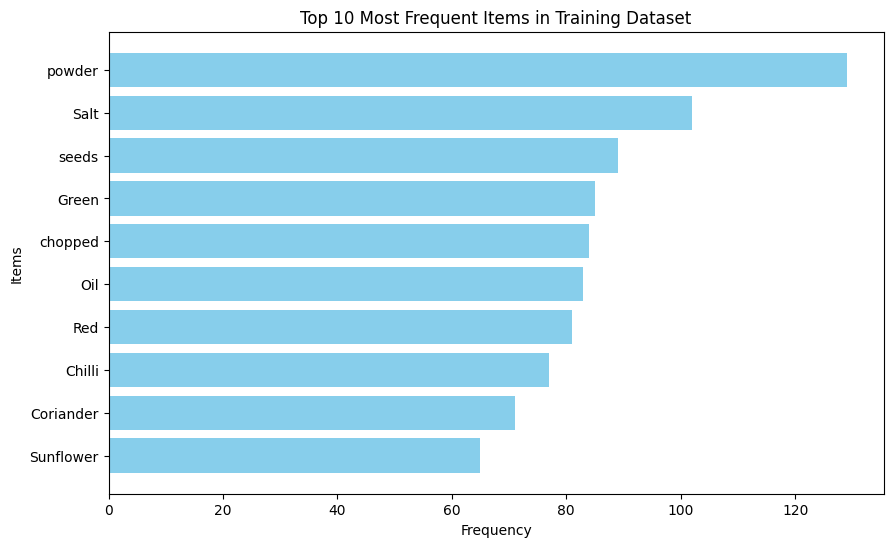

In [58]:
# plot the top frequent ingredients in training data
plot_top_items(ingredient_tokens, 'Training', top_n=10)

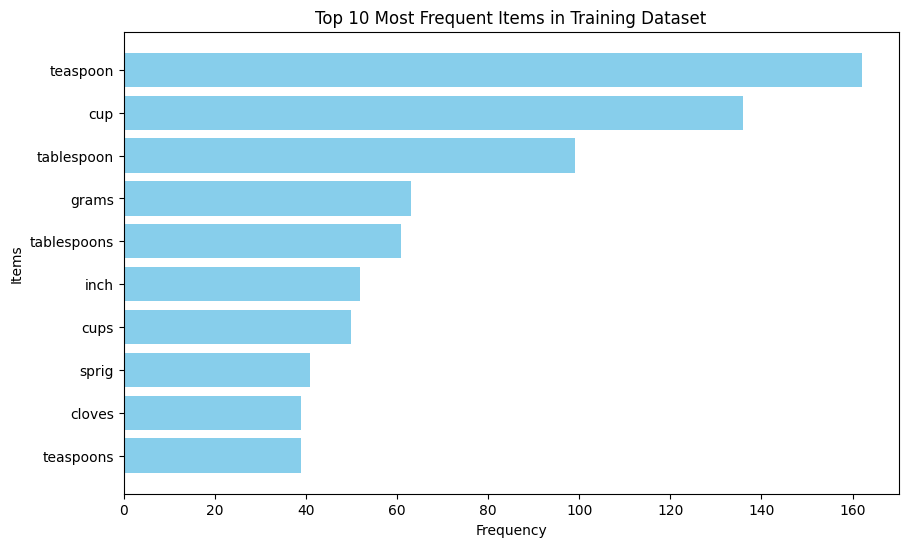

In [59]:
# plot the top frequent units in training data

plot_top_items(unit_tokens, 'Training', top_n=10)

## **5** Exploratory Recipe Data Analysis on Validation Dataset (Optional)<font color = red> [0 marks]</font> <br>

#### **5.1** *Execute EDA on Validation Dataset with insights (Optional)* <font color = red> [0 marks]</font> <br>
Initialise the dataset_name as ***Validation*** and call the ***plot_top_items*** for top 10 ingredients and units in the recipe data
Provide the insights for the same.



In [ ]:
# initialise the dataset_name


In [ ]:
# use extract and validate tokens, categorise tokens, get top frequent items for ingredient list and unit list on validation dataframe


In [ ]:
# plot the top frequent ingredients in validation data


In [ ]:
# plot the top frequent units in training data


## **6** Feature Extraction For CRF Model <font color = red>[30 marks]</font> <br>

### **6.1** *Define a feature functions to take each token from recipe* <font color = red>[10 marks]</font>

Define a function as ***word2features*** which takes a particular recipe and its index to work with all recipe input tokens and include custom key-value pairs.

Also, use feature key-value pairs to mark the beginning and end of the sequence and to also check whether the word belongs to unit, quantity etc. Use keyword sets for unit and quantity for differentiating feature functions well. Also make use of relevant regex patterns on fractions, whole numbers etc.

##### **6.1.1** **Define keywords for unit and quantity and create a quantity pattern to work on fractions, numbers and decimals** <font color = red>[3 marks]</font> <br>

Create sets for **unit_keywords** and ***quantity_keywords*** and include all the words relevant for measuring the ingredients such as cup, tbsp, tsp etc. and in quantity keywords, include words such as half, quarter etc.

Also suggested to use regex pattern as ***quantity_pattern*** to work with quantity in any format such as fractions, numbers and decimals.

Then, load the spacy model and process the entire sentence

In [60]:
# define unit and quantity keywords along with quantity pattern
# 1. Define the unit_keywords and quantity_keywords sets
unit_keywords = {"cup", "tbsp", "tsp", "oz", "ml", "liter", "g", "kg", "pound", "ounce", "liter", "cl"}
quantity_keywords = {"half", "quarter", "third", "two", "one", "one-half", "one-quarter", "three", "four"}

# 2. Define the regex pattern for matching quantities like fractions, numbers, and decimals
quantity_pattern = r"(\d+/\d+|\d+\.\d+|\d+|\d+\s+?\d+/\d+|\d+\s+\d+\.\d+)"

In [61]:
# load spaCy model
nlp = spacy.load("en_core_web_sm")

##### **6.1.2** **Define feature functions for CRF** <font color = red>[7 marks]</font> <br>

Define ***word2features*** function and use the parameters such as sentence and its indexing as ***sent*** and ***i*** for extracting token level features for CRF Training.
Build ***features*** dictionary, also mark the beginning and end of the sequence and use the ***unit_keywords***, ***quantity_keywords*** and ***quantity_pattern*** for knowing the presence of quantity or unit in the tokens

While building ***features*** dictionary, include
- ***Core Features*** - The core features of a token should capture its lexical
and grammatical properties. Include attributes like the raw token, its lemma, part-of-speech tag, dependency relation, and shape, as well as indicators for whether it's a stop word, digit, or punctuation. The details of the features are given below:

    - `bias` - Constant feature with a fixed value of 1.0 to aid model learning.
    - `token` - The lowercase form of the current token.
    - `lemma` - The lowercase lemma (base form) of the token.
    - `pos_tag` - Part-of-speech (POS) tag of the token.
    - `tag` - Detailed POS tag of the token.
    - `dep` - Dependency relation of the token in the sentence.
    - `shape` - Shape of the token (e.g., "Xxx" for "Milk").
    - `is_stop` - Boolean indicating if the token is a stopword.
    - `is_digit` - Boolean indicating if the token consists of only digits.
    - `has_digit` - Boolean indicating if the token contains at least one digit.
    - `has_alpha` - Boolean indicating if the token contains at least one alphabetic character.
    - `hyphenated` - Boolean indicating if the token contains a hyphen (-).
    - `slash_present` - Boolean indicating if the token contains a slash (/).
    - `is_title` - Boolean indicating if the token starts with an uppercase letter.
    - `is_upper` - Boolean indicating if the token is fully uppercase.
    - `is_punct` - Boolean indicating if the token is a punctuation mark.

- ***Improved Quantity and Unit Detection*** - Use key-value pairs to mark the presence of quantities and units in the features dictionary. Utilise the unit_keywords, quantity_keywords, and quantity_pattern to identify and flag these elements. The details of the features are given below:

    - `is_quantity` - Boolean indicating if the token matches a quantity pattern or keyword.
    - `is_unit` - Boolean indicating if the token is a known measurement unit.
    - `is_numeric` - Boolean indicating if the token matches a numeric pattern.
    - `is_fraction` - Boolean indicating if the token represents a fraction (e.g., 1/2).
    - `is_decimal` - Boolean indicating if the token represents a decimal number (e.g., 3.14).
    - `preceding_word` - The previous token in the sentence, if available.
    - `following_word` - The next token in the sentence, if available.

- ***Contextual Features*** - Incorporate contextual information by adding features for the preceding and following tokens. Include indicators like BOS and EOS to mark the beginning and end of the sequence, and utilise unit_keywords, quantity_keywords, and quantity_pattern to identify the types of neighboring tokens. The features are given below:

    - `prev_token` - The lowercase form of the previous token.
    - `prev_is_quantity` - Boolean indicating if the previous token is a quantity.
    - `prev_is_digit` - Boolean indicating if the previous token is a digit.
    - `BOS` - Boolean indicating if the token is at the beginning of the sentence.
    - `next_token` - The lowercase form of the next token.
    - `next_is_unit` - Boolean indicating if the next token is a unit.
    - `next_is_ingredient` - Boolean indicating if the next token is not a unit or quantity.
    - `EOS` - Boolean indicating if the token is at the end of the sentence.



In [62]:
# define word2features for processing each token in the sentence sent by using index i.
# use your own feature functions

def word2features(sentence, i):
    """
    Extract token-level features for CRF training, capturing core features,
    quantity and unit detection, and contextual information for a given token
    in the sentence.

    Args:
        sentence (list): List of tokens (words) in the sentence.
        i (int): Index of the current token in the sentence.

    Returns:
        dict: Feature dictionary for the token at index i in the sentence.
    """
    features = {}

    # --- Process the entire sentence with spaCy ---
    word = sentence[i]
    doc = nlp(word)
    lemma = doc[0].lemma_  # Lemmatized form of the word
    pos = doc[0].pos_  # POS tag
    tag = doc[0].tag_  # Detailed POS tag
    dep = doc[0].dep_  # Dependency relation
    shape = doc[0].shape_  # Token shape (e.g., "Xxx" for "Milk")

    # --- Core Features ---
    features["bias"] = 1.0
    features["token"] = word.lower()
    features["lemma"] = lemma.lower()
    features["pos_tag"] = pos
    features["tag"] = tag
    features["dep"] = dep
    features["shape"] = shape
    features["is_stop"] = word.lower() in nlp.Defaults.stop_words
    features["is_digit"] = word.isdigit()
    features["has_digit"] = any(char.isdigit() for char in word)
    features["has_alpha"] = any(char.isalpha() for char in word)
    features["hyphenated"] = '-' in word
    features["slash_present"] = '/' in word
    features["is_title"] = word.istitle()
    features["is_upper"] = word.isupper()
    features["is_punct"] = word in ",.!?;:"

    # --- Improved Quantity & Unit Detection ---
    features["is_quantity"] = bool(re.match(quantity_pattern, word))
    features["is_unit"] = word.lower() in unit_keywords
    features["is_numeric"] = word.isdigit()
    features["is_fraction"] = bool(re.match(r"\d+/\d+", word))
    features["is_decimal"] = bool(re.match(r"\d+\.\d+", word))

    # --- Contextual Features ---
    if i > 0:
        prev_token = sentence[i - 1]
        prev_doc = nlp(prev_token)
        prev_is_quantity = bool(re.match(quantity_pattern, prev_token))
        prev_is_digit = prev_token.isdigit()
    else:
        prev_token = "<BOS>"  # Beginning of sequence
        prev_is_quantity = False
        prev_is_digit = False

    if i < len(sentence) - 1:
        next_token = sentence[i + 1]
        next_doc = nlp(next_token)
        next_is_unit = next_token.lower() in unit_keywords
        next_is_ingredient = not (next_token.lower() in unit_keywords or bool(re.match(quantity_pattern, next_token)))
    else:
        next_token = "<EOS>"  # End of sequence
        next_is_unit = False
        next_is_ingredient = False

    # Add contextual features to the dictionary
    features["prev_token"] = prev_token.lower()
    features["prev_is_quantity"] = prev_is_quantity
    features["prev_is_digit"] = prev_is_digit
    features["BOS"] = (i == 0)  # Beginning of sequence
    features["next_token"] = next_token.lower()
    features["next_is_unit"] = next_is_unit
    features["next_is_ingredient"] = next_is_ingredient
    features["EOS"] = (i == len(sentence) - 1)  # End of sequence

    return features


### **6.2** *Preparation of Recipe level features* <font color = red>[2 marks]</font>


##### **6.2.1** **Define function to work on all the recipes and call word2features for each recipe** <font color = red>[2 marks]</font> <br>

Define ***sent2features*** function and inputs ***sent*** as a parameter and correctly generate feature functions for each token present in the sentence

In [63]:
# define sent2features by working on each token in the sentence and correctly generate dictionaries for features
def sent2features(sent):
    """
    Extract features for each token in the sentence using the word2features function.

    Args:
        sent (list): List of tokens (words) in the sentence.

    Returns:
        list: List of feature dictionaries for each token in the sentence.
    """
    return [word2features(sent, i) for i in range(len(sent))]

### **6.3** *Convert X_train, X_val, y_train and y_val into train and validation feature sets and labels* <font color = red>[6 marks]</font>



##### **6.3.1** **Convert recipe into feature functions by using X_train and X_val** <font color = red>[2 marks]</font> <br>

Create ***X_train_features*** and ***X_val_features*** as list to include the feature functions for each recipe present in training and validation sets

In [68]:
def generate_features(df):
    """
    Generates feature sets for the input tokens of each recipe in the dataframe.

    Args:
        df (pd.DataFrame): DataFrame containing the input_tokens and pos_tokens columns.

    Returns:
        list: A list of feature dictionaries for each recipe.
    """
    features_list = []
    for _, row in df.iterrows():
        sentence = row['input_tokens']  # Extract the input tokens from the dataframe row
        features_list.append(sent2features(sentence))  # Generate features using the sent2features function
    return features_list

# Generate features for the training and validation datasets
X_train_features = generate_features(pd.DataFrame(X_train))  # Apply on training data
X_val_features = generate_features(pd.DataFrame(X_val)) # Applying on validation data

##### **6.3.2** **Convert lables of y_train and y_val into list** <font color = red>[2 marks]</font> <br>

Create ***y_train_labels*** and ***y_val_labels*** by using the list of y_train and y_val

In [70]:
# Convert labels into list as y_train_labels and y_val_labels
def extract_labels(df):
    """
    Extracts the labels (POS tags) from the dataframe and returns them as a list of lists.

    Args:
        df (pd.DataFrame): DataFrame containing the 'pos_tokens' column, where each row is a list of POS tags.

    Returns:
        list: A list of lists where each sublist contains POS tags corresponding to each token in a sentence.
    """
    labels_list = []
    for _, row in df.iterrows():
        pos_tags = row['pos_tokens']  # Extract the list of POS tags for each row
        labels_list.append(pos_tags)  # Append to the labels list
    return labels_list

# Extract labels for training and validation datasets
y_train_labels = extract_labels(pd.DataFrame(y_train))  # Assuming 'train_df' contains the 'pos_tokens' column
y_val_labels = extract_labels(pd.DataFrame(y_val))

##### **6.3.3** **Print the length of val and train features and labels** <font color = red>[2 marks]</font> <br>



In [71]:
# print the length of train features and labels
len(X_train_features), len(y_train_labels)

(196, 196)

In [72]:
# print the length of validation features and labels
len(X_val_features), len(y_val_labels)

(84, 84)

### **6.4** *Applying weights to feature sets* <font color = red>[12 marks]</font> <br>




##### **6.4.1** **Flatten the labels of y_train** <font color = red>[2 marks]</font> <br>

Create ***y_train_flat*** to flatten the structure of nested y_train

In [73]:
# Flatten labels in y_train
def flatten_labels(nested_labels):
    """
    Flattens a list of lists of POS tags into a single list.

    Args:
        nested_labels (list of list of str): Nested list of POS tags.

    Returns:
        list of str: Flattened list of POS tags.
    """
    return [label for sublist in nested_labels for label in sublist]

y_train_flat = flatten_labels(y_train_labels)

##### **6.4.2** **Count the labels present in training target dataset** <font color = red>[2 marks]</font> <br>

Create ***label_counts*** to count the frequencies of labels present in y_train_flat and retrieve the total samples by using the values of label_counts as ***total_samples***

In [75]:
# Count label frequencies as label_counts and total_samples as getting the summation of values of label_counts
# Count the frequency of each label in the flattened list
label_counts = Counter(y_train_flat)

# Total number of POS-tagged tokens
total_samples = sum(label_counts.values())
print("Label Frequencies:\n", label_counts)
print("\nTotal Samples:", total_samples)

Label Frequencies:
 Counter({'ingredient': 5323, 'quantity': 980, 'unit': 811})

Total Samples: 7114


##### **6.4.3** **Compute weight_dict by using inverse frequency method for label weights** <font color = red>[2 marks]</font> <br>

- Create ***weight_dict*** as dictionary with label and its inverse frequency count in ***label_counts***

- Penalise ingredient label in the dictionary

In [76]:
# Compute class weights (inverse frequency method) by considering total_samples and label_counts
def compute_inverse_weights(label_counts, penalize_label=None, penalize_factor=0.5):
    """
    Computes inverse frequency weights for each label.

    Args:
        label_counts (Counter): Dictionary of label frequencies.
        penalize_label (str): Label to penalize by a factor (e.g., 'ingredient').
        penalize_factor (float): Factor by which to penalize the given label.

    Returns:
        dict: Dictionary with labels and their inverse frequency weights.
    """
    total_samples = sum(label_counts.values())
    weight_dict = {}

    for label, count in label_counts.items():
        weight = total_samples / count
        if label == penalize_label:
            weight *= penalize_factor  # Penalize the specified label
        weight_dict[label] = weight

    return weight_dict

In [77]:
# penalise ingredient label
weight_dict = compute_inverse_weights(label_counts, penalize_label='ingredient', penalize_factor=0.5)

##### **6.4.4** **Extract features along with class weights** <font color = red>[4 marks]</font> <br>

Define a function ***extract_features_with_class_weights*** to work with training and validation datasets and extract features by applying class weights





In [80]:
# Apply weights to feature extraction in extract_features_with_class_weights by using parameters such as X (input tokens), y(labels) and weight_dict (Class weights)
def extract_features_with_class_weights(X, y, weight_dict):
    """
    Extracts features and applies class weights to each token in the input data.

    Parameters:
        X (pd.Series): Series of input token lists (e.g., input_tokens).
        y (pd.Series): Series of corresponding POS label lists (e.g., pos_tokens).
        weight_dict (dict): Dictionary mapping labels to inverse frequency weights.

    Returns:
        X_features (List[List[dict]]): Feature dictionaries for each token.
        y_labels (List[List[str]]): Original labels.
        sample_weights (List[List[float]]): Weights for each token based on labels.
    """
    X_features = []
    y_labels = []
    sample_weights = []

    for sentence_tokens, label_sequence in zip(X, y):
        features = sent2features(sentence_tokens)
        weights = [weight_dict.get(label, 1.0) for label in label_sequence]  # Default weight 1.0 if label not in dict

        X_features.append(features)
        y_labels.append(label_sequence)
        sample_weights.append(weights)

    return X_features, y_labels, sample_weights

##### **6.4.5** **Execute extract_features_with_class_weights on training and validation datasets** <font color = red>[2 marks]</font> <br>

Create ***X_train_weighted_features*** and ***X_val_weighted_features*** for extracting training and validation features along with their weights by calling ***extract_features_with_class_weights*** on the datasets

In [82]:
# Apply manually computed class weights
X_train_weighted_features, y_train_labels, train_sample_weights = extract_features_with_class_weights(
    train_df['input_tokens'], train_df['pos_tokens'], weight_dict
)

X_val_weighted_features, y_val_labels, val_sample_weights = extract_features_with_class_weights(
    val_df['input_tokens'], val_df['pos_tokens'], weight_dict
)

## **7** Model Building and Training <font color = red>[10 marks]</font> <br>

### **7.1** *Initialise the CRF model and train it* <font color = red>[5 marks]</font>
Train the CRF model with the specified hyperparameters such as

### CRF Model Hyperparameters Explanation

| Parameter                  | Description |
|----------------------------|-------------|
| **algorithm='lbfgs'**      | Optimisation algorithm used for training. `lbfgs` (Limited-memory Broyden–Fletcher–Goldfarb–Shanno) is a quasi-Newton optimisation method. |
| **c1=0.5**                | L1 regularisation term to control sparsity in feature weights. Helps in feature selection. |
| **c2=1.0**                | L2 regularisation term to prevent overfitting by penalising large weights. |
| **max_iterations=100**     | Maximum number of iterations for model training. Higher values allow more convergence but increase computation time. |
| **all_possible_transitions=True** | Ensures that all possible state transitions are considered in training, making the model more robust. |

Use weight_dict for training CRF



In [84]:
# initialise CRF model with the specified hyperparameters and use weight_dict
from sklearn_crfsuite import CRF
crf = CRF(
    algorithm='lbfgs',
    c1=0.5,
    c2=1.0,
    max_iterations=100,
    all_possible_transitions=True
)

# train the CRF model with the weighted training data
crf.fit(X_train_weighted_features, y_train_labels)

CRF(algorithm='lbfgs', all_possible_transitions=True, c1=0.5, c2=1.0,
    max_iterations=100)

### **7.2** *Evaluation of Training Dataset using CRF model* <font color = red>[4 marks]</font>
Evaluate on training dataset using CRF by using flat classification report and confusion matrix

In [85]:
# evaluate on the training dataset
y_train_pred = crf.predict(X_train_weighted_features)

In [86]:
# specify the flat classification report by using training data for evaluation
print("Training Set Evaluation")
print(flat_classification_report(y_train_labels, y_train_pred))

Training Set Evaluation
              precision    recall  f1-score   support

  ingredient       0.99      1.00      0.99      5323
    quantity       1.00      0.98      0.99       980
        unit       0.99      0.96      0.97       811

    accuracy                           0.99      7114
   macro avg       0.99      0.98      0.99      7114
weighted avg       0.99      0.99      0.99      7114



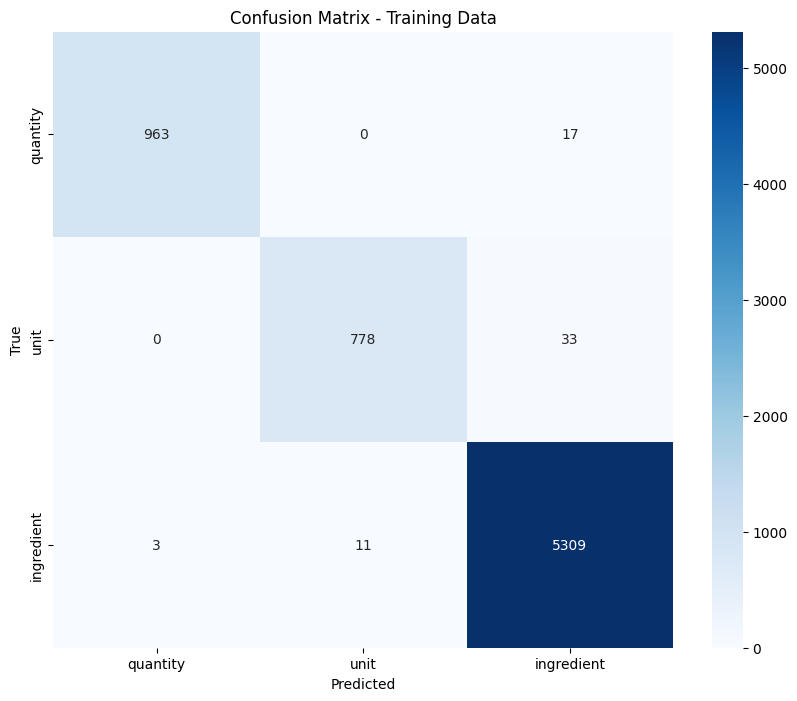

In [89]:
# create a confusion matrix on training datset
labels = list(crf.classes_)  # Get list of POS labels
cm = confusion_matrix(np.concatenate(y_train_labels), np.concatenate(y_train_pred), labels=labels)

# Plot confusion matrix
plt.figure(figsize=(10, 8))
sns.heatmap(cm, annot=True, fmt="d", cmap="Blues", xticklabels=labels, yticklabels=labels)
plt.title("Confusion Matrix - Training Data")
plt.xlabel("Predicted")
plt.ylabel("True")
plt.show()

### **7.3** *Save the CRF model* <font color = red>[1 marks]</font>
Save the CRF model

In [90]:
# dump the model using joblib as crf_model.pkl
import pickle

# Save the trained CRF model to a file
with open('trained_crf_model.pkl', 'wb') as f:
    pickle.dump(crf, f)

print("CRF model saved successfully!")

CRF model saved successfully!


## **8** Prediction and Model Evaluation <font color = red>[3 marks]</font> <br>

### **8.1** *Predict and Evaluate the CRF model on validation set* <font color = red>[3 marks]</font>
Evaluate the metrics for CRF model by using flat classification report and confusion matrix




In [91]:
# predict the crf model on validation dataset
y_val_pred = crf.predict(X_val_weighted_features)

In [92]:
# specify flat classification report
print("Validation Set Evaluation - Classification Report")
print(flat_classification_report(y_val_labels, y_val_pred))

Validation Set Evaluation - Classification Report
              precision    recall  f1-score   support

  ingredient       0.98      1.00      0.99      2107
    quantity       0.99      0.99      0.99       411
        unit       0.98      0.91      0.94       358

    accuracy                           0.98      2876
   macro avg       0.98      0.96      0.97      2876
weighted avg       0.98      0.98      0.98      2876



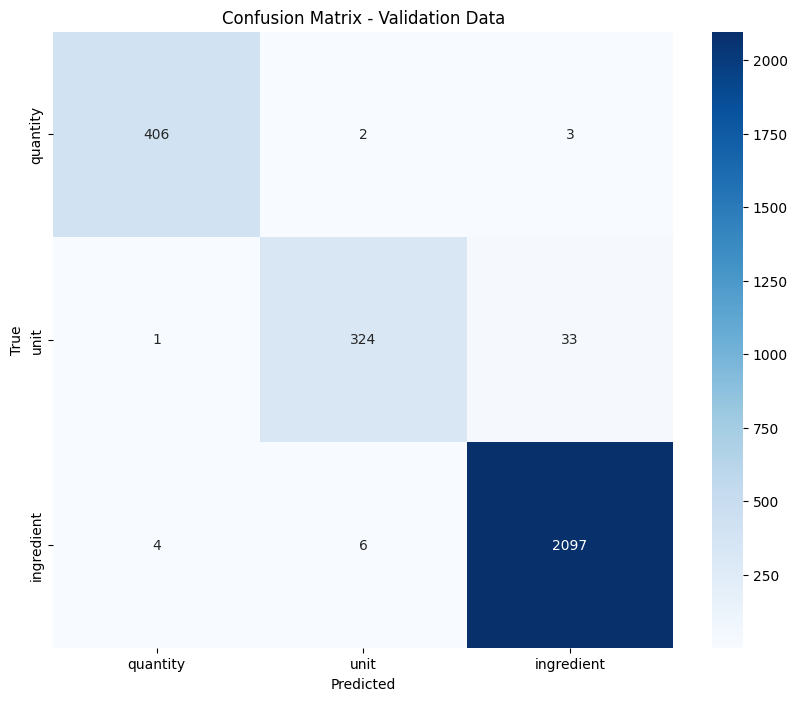

In [93]:
# create a confusion matrix on validation dataset
labels = list(crf.classes_)  # Get list of POS labels
cm = confusion_matrix(np.concatenate(y_val_labels), np.concatenate(y_val_pred), labels=labels)

# Plot confusion matrix
plt.figure(figsize=(10, 8))
sns.heatmap(cm, annot=True, fmt="d", cmap="Blues", xticklabels=labels, yticklabels=labels)
plt.title("Confusion Matrix - Validation Data")
plt.xlabel("Predicted")
plt.ylabel("True")
plt.show()

## **9** Error Analysis on Validation Data <font color = red>[10 marks]</font> <br>
Investigate misclassified samples in validation dataset and provide the insights


### **9.1** *Investigate misclassified samples in validation dataset* <font color = red>[8 marks]</font>



##### **9.1.1** Flatten the labels of validation data and initialise error data <font color = red>[2 marks]</font> <br>



Flatten the true and predicted labels and initialise the error data as ***error_data***

In [96]:
# flatten Labels and Initialise Error Data
y_val_true_flat = np.concatenate(y_val_labels)
y_val_pred_flat = np.concatenate(y_val_pred)

# Initialize error data as a list of misclassified instances
error_data = []

##### **9.1.2** Iterate the validation data and collect Error Information<font color = red> [2 marks]</font> <br>



Iterate through validation data (X_val, y_val_labels, y_pred_val) and compare true vs. predicted labels. Collect error details, including surrounding context, previous/next tokens, and class weights, then store them in error_data

In [98]:
# Loop using index and access rows via .iloc
for idx in range(len(X_val)):
    true_labels = y_val_labels[idx]
    pred_labels = y_val_pred[idx]
    tokens = X_val.iloc[idx]  # FIXED: use .iloc here

    for token_idx in range(len(true_labels)):
        true_label = true_labels[token_idx]
        pred_label = pred_labels[token_idx]

        if true_label != pred_label:
            # Previous/next token handling
            prev_token = tokens[token_idx - 1] if token_idx > 0 else "<BOS>"
            next_token = tokens[token_idx + 1] if token_idx < len(tokens) - 1 else "<EOS>"

            prev_pos = true_labels[token_idx - 1] if token_idx > 0 else "<BOS>"
            next_pos = true_labels[token_idx + 1] if token_idx < len(true_labels) - 1 else "<EOS>"

            error_data.append({
                'index': idx,
                'token': tokens[token_idx],
                'true_label': true_label,
                'predicted_label': pred_label,
                'previous_token': prev_token,
                'next_token': next_token,
                'previous_pos': prev_pos,
                'next_pos': next_pos,
                'class_weight': weight_dict.get(true_label, 1)
            })

print(f"Number of misclassified tokens: {len(error_data)}")
print("Sample error data:", error_data[:3])

Number of misclassified tokens: 49
Sample error data: [{'index': 2, 'token': 'few', 'true_label': 'ingredient', 'predicted_label': 'quantity', 'previous_token': 'Leaves', 'next_token': '<EOS>', 'previous_pos': 'ingredient', 'next_pos': '<EOS>', 'class_weight': 0.6682321998872816}, {'index': 5, 'token': 'cloves', 'true_label': 'ingredient', 'predicted_label': 'unit', 'previous_token': '3', 'next_token': 'garlic', 'previous_pos': 'quantity', 'next_pos': 'ingredient', 'class_weight': 0.6682321998872816}, {'index': 5, 'token': 'Spoon', 'true_label': 'unit', 'predicted_label': 'ingredient', 'previous_token': 'big', 'next_token': 'oil', 'previous_pos': 'ingredient', 'next_pos': 'ingredient', 'class_weight': 8.771886559802713}]


##### **9.1.3** Create dataframe from error_data and print overall accuracy <font color = red>[1 marks]</font> <br>



Change error_data into dataframe and then use it to illustrate the overall accuracy of validation data

In [101]:
from itertools import chain
from sklearn.metrics import accuracy_score
# Create DataFrame and Print Overall Accuracy
error_df = pd.DataFrame(error_data)

# Step 2: Flatten the true and predicted labels for validation
y_val_true_flat = list(chain.from_iterable(y_val_labels))
y_val_pred_flat = list(chain.from_iterable(y_val_pred))

# Step 3: Calculate Accuracy
val_accuracy = accuracy_score(y_val_true_flat, y_val_pred_flat)

# Step 4: Print results
print("Validation Accuracy:", round(val_accuracy * 100, 2), "%")
print("\nSample of Misclassified Tokens:")
print(error_df.head())


Validation Accuracy: 98.3 %

Sample of Misclassified Tokens:
   index   token  true_label predicted_label previous_token next_token previous_pos    next_pos  class_weight
0      2     few  ingredient        quantity         Leaves      <EOS>   ingredient       <EOS>      0.668232
1      5  cloves  ingredient            unit              3     garlic     quantity  ingredient      0.668232
2      5   Spoon        unit      ingredient            big        oil   ingredient  ingredient      8.771887
3      6  cloves        unit      ingredient          seeds     garlic   ingredient  ingredient      8.771887
4     12    gram        unit      ingredient             50  Spaghetti     quantity  ingredient      8.771887


##### **9.1.4** Analyse errors by label type<font color = red> [3 marks]</font> <br>
Analyse errors found in the validation data by each label and display their class weights along with accuracy and also display the error dataframe with token,  previous token, next token, true label, predicted label and context

In [103]:
# Analyse errors found in the validation data by each label
# and display their class weights along with accuracy
# and display the error dataframe with token, previous token, next token, true label, predicted label and context

from collections import defaultdict
import pandas as pd
import numpy as np

# Flatten true and predicted labels
y_val_true_flat = list(chain.from_iterable(y_val_labels))
y_val_pred_flat = list(chain.from_iterable(y_val_pred))

# Create a DataFrame with tokens and labels
token_error_df = pd.DataFrame(error_data)

# Add a 'label_match' column for comparison
token_error_df['label_match'] = token_error_df['true_label'] == token_error_df['predicted_label']

# Group by true label to calculate per-label accuracy
label_accuracy = (
    token_error_df.groupby('true_label')['label_match']
    .agg(['sum', 'count'])
    .rename(columns={'sum': 'correct', 'count': 'total'})
)
label_accuracy['accuracy (%)'] = (label_accuracy['correct'] / label_accuracy['total'] * 100).round(2)

# Add class weights to the accuracy DataFrame
label_accuracy['class_weight'] = label_accuracy.index.map(weight_dict)

# Sort by accuracy
label_accuracy = label_accuracy.sort_values(by='accuracy (%)')

# Print summary
print("🔍 Label-wise Error Analysis:\n")
print(label_accuracy)

# Show error sample with context
error_cols = ['token', 'prev_token', 'next_token', 'true_label', 'predicted_label', 'context']
# Display what columns are actually available
print("Available columns in error_data:", token_error_df.columns.tolist())

# Define only columns that exist
available_cols = [col for col in ['token', 'prev_token', 'next_token', 'true_label', 'predicted_label', 'context']
                  if col in token_error_df.columns]

# Display sample errors with available columns
print("\n🧪 Sample Errors with Context:\n")
print(token_error_df[~token_error_df['label_match']][available_cols].head(10))

🔍 Label-wise Error Analysis:

            correct  total  accuracy (%)  class_weight
true_label                                            
ingredient        0     10           0.0      0.668232
quantity          0      5           0.0      7.259184
unit              0     34           0.0      8.771887
Available columns in error_data: ['index', 'token', 'true_label', 'predicted_label', 'previous_token', 'next_token', 'previous_pos', 'next_pos', 'class_weight', 'label_match']

🧪 Sample Errors with Context:

    token   next_token  true_label predicted_label
0     few        <EOS>  ingredient        quantity
1  cloves       garlic  ingredient            unit
2   Spoon          oil        unit      ingredient
3  cloves       garlic        unit      ingredient
4    gram    Spaghetti        unit      ingredient
5      is            2    quantity      ingredient
6     few        <EOS>  ingredient        quantity
7  cloves       Garlic        unit      ingredient
8      to  tablespoons    qu

### **9.2** *Provide insights from the validation dataset* <font color = red>[2 marks]</font>




 <font color = red>[1. Few labels might have been misunderstood due to keyword overlap. Needs clearer contextual cues]</font>
 <font color = red>[2. There is some confusion between ingredients and units. Possibly a POS tag issue or misaligned context]</font>
 <font color = red>[3. Certain usage of next token with a particular token is creating some confusion]</font>

## **10** Conclusion (Optional) <font color = red>[0 marks]</font> <br>

Write your findings and conclusion.